## Importing the necessary libraries

In [1]:
# Importing the dependencies
import tensorflow as tf
from tensorflow import keras
from keras import models,layers
import numpy as np
import matplotlib.pyplot as plt
import os
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

When working with lots of real-world image data, corrupted images are a common occurence. Let's filter out badly-encoded images that do not feature the string "JFIF" in their header.

In [2]:
# Variable to keep track of number of corrupt images
num_skipped = 0

for folder_name in ("Apple___Cedar_apple_rust", "Apple___healthy"):
    folder_path = os.path.join("data", folder_name)

    # Iterating through each and every file(image) in the respective directory
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

# Let's see how many corrupt images are there
print("Deleted %d images" % num_skipped)

Deleted 0 images


In [3]:
# Loading the data into the tensorflow dataset
dataset = keras.preprocessing.image_dataset_from_directory("data/", batch_size=32, image_size=(256, 256), shuffle=True)
class_names = dataset.class_names


print("Class names are : ",class_names)
print(f"Our data is in total : {len(dataset)} batches")

Found 4710 files belonging to 2 classes.
Class names are :  ['Apple___Cedar_apple_rust', 'Apple___healthy']
Our data is in total : 148 batches


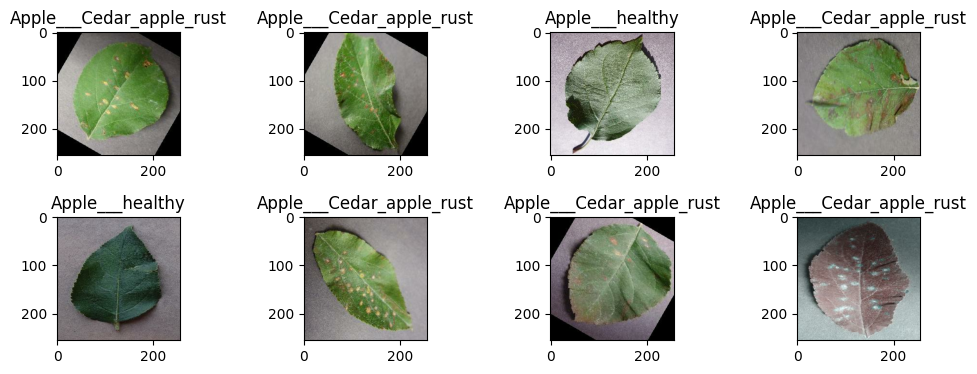

In [3]:
# Let's visualize one of the image from the batch
fig, ax = plt.subplots(2,4,figsize=(12, 4))

# Printing 8 images from the first batch of the dataset
for img_batch, label_batch in dataset.take(1):

    for i in range(2):
        for j in range(4):
            ax[i, j].set_title(class_names[label_batch[i * 4 + j]])
            ax[i, j].imshow(img_batch[i * 4 + j].numpy().astype("uint8"))

# Adjusting the spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.show()

In [4]:
# training size, validation size, shuffle size
training_size = 0.8
validation_size = 0.1
shuffle_size = 10000

# Function for creating test, train and validation data batches
def train_test_val_batches(dataset, training_size, validation_size, shuffle_size):

    # Shuffling the dataset
    dataset = dataset.shuffle(shuffle_size, seed=12)

    # Creating batches for train, test, and validation
    train_dataset = dataset.take(int(len(dataset) * training_size)) #118 batches will be there in training dataset
    test_dataset = dataset.skip(int(len(dataset) * training_size)) # 29 in the test data
    validation_dataset = test_dataset.take(int(len(test_dataset) * validation_size))

    # Cache, Shuffle, and Prefetch the Datasets
    train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    validation_dataset = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, test_dataset, validation_dataset


# Calling the function
train_ds, test_ds, val_ds = train_test_val_batches(dataset, training_size, validation_size, shuffle_size)

Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it.

Image Preprocessing:

Apply image preprocessing techniques like noise removal, sharpening, or contrast adjustment to enhance the visual features.
These techniques can help highlight important patterns and make the disease symptoms more distinguishable.

Data Augmentation
Image Resizing
Image Normalization

## Processing the images

For processing the raw images which includes data augmentation, image resizing, image rescaling etc we will be using the keras preprocessing layers API that will help us to build the preprocessing pipeline very much easily.

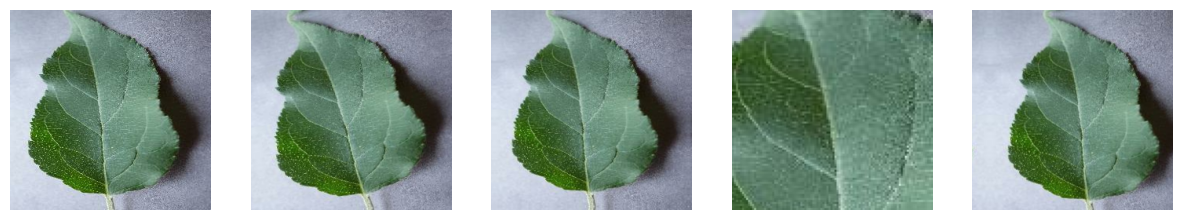

In [47]:
# Create the data augmentation model
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomCrop(100, 100),
    tf.keras.layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)
])

# Now just for testing let's take a single image and apply preprocessing on it
for img,labels in train_ds.take(1):
    single_img = img[0].numpy()
    break

# Apply data augmentation to the single image
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i, layer in enumerate(data_augmentation.layers):
    augmented_image = layer(tf.expand_dims(single_img, axis=0), training=True)
    ax[i].imshow(augmented_image[0].numpy().astype("uint8"))
    ax[i].axis("off")

plt.show()

In [6]:
input_shape = (32, 256, 256, 3)
n_classes = 2

model = models.Sequential([

    # First we will resize and rescale our images
    resize_and_rescale,

    # We will create new data for making our model robust
    data_augmentation,

    # Let's now add conovlutional and pooling layers
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Flattening the feature map for feeding in vanilla artificial neural network
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

# Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [7]:
# Let's get the entire summary of our model
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [8]:
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
118/118 [==============================] - 129s 783ms/step - loss: 0.3059 - accuracy: 0.8669 - val_loss: 0.0557 - val_accuracy: 0.9688
Epoch 2/50
118/118 [==============================] - 56s 475ms/step - loss: 0.0760 - accuracy: 0.9752 - val_loss: 0.0760 - val_accuracy: 0.9896
Epoch 3/50
118/118 [==============================] - 46s 388ms/step - loss: 0.0646 - accuracy: 0.9792 - val_loss: 0.0466 - val_accuracy: 0.9896
Epoch 4/50
118/118 [==============================] - 50s 421ms/step - loss: 0.0531 - accuracy: 0.9816 - val_loss: 0.2206 - val_accuracy: 0.9375
Epoch 5/50
118/118 [==============================] - 47s 397ms/step - loss: 0.0624 - accuracy: 0.9805 - val_loss: 0.0351 - val_accuracy: 0.9896
Epoch 6/50
118/118 [==============================] - 44s 367ms/step - loss: 0.0330 - accuracy: 0.9904 - val_loss: 0.0847 - val_accuracy: 0.9688
Epoch 7/50
118/118 [==============================] - 46s 387ms/step - loss: 0.0165 - accuracy: 0.9947 - val_loss: 0.0114 - val_a

In [10]:
# Saving the model
current_model_version = 1
model.save(f"Models/{current_model_version}")